In [4]:
import os

# uncomment to disable NVIDIA GPUs
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
# or pick the device (cpu, gpu, and tpu)
#os.environ['JAX_PLATFORMS'] = 'cpu'

# change JAX GPU memory preallocation fraction
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

import jax
import jax.numpy as jnp

from pmwd import (
    Configuration,
    SimpleLCDM,
    boltzmann,
    white_noise, linear_modes,
    lpt,
    nbody,
    scatter,
)
from pmwd.vis_util import simshow
from pmwd.spec_util import powspec

NVIDIA A100-PCIE-40GB


Setup, do a coarse run for now

In [5]:
conf_lpt

NameError: name 'conf_lpt' is not defined

In [ ]:
    # def box_size(self):
    #     """Simulation box size tuple in [L]."""
    #     return tuple(self.ptcl_spacing * s for s in self.ptcl_grid_shape)

In [35]:
ptcl_spacing_lpt,ptcl_spacing_sub

(4.0, 4.0)

In [36]:
ptcl_grid_shape

(8, 8, 8)

In [37]:
jax.lib.xla_bridge.get_backend().platform

'cpu'

In [45]:
downsample_fac = 8
big_box = 1000.0
N_sub = 8
N_sub_1d = 2
sub_res = 128


ptcl_spacing_sub,ptcl_grid_shape_sub,mesh_shape_sub = big_box/N_sub_1d/sub_res,(sub_res,)*3,2
ptcl_spacing_lpt,ptcl_grid_shape_lpt,mesh_shape_lpt = big_box/N_sub_1d, (2,) * 3,2 #FIXME do  we want 1?


# separate grids for lpt and subbox
#FIXME we will later expand "subbox" to tile with teh buffer zone

conf_lpt = Configuration(ptcl_spacing_lpt, ptcl_grid_shape_lpt, mesh_shape=mesh_shape_lpt)  
conf_sub = Configuration(ptcl_spacing_sub, ptcl_grid_shape_sub, mesh_shape=ptcl_grid_shape_sub)

seed = 0
cosmo = SimpleLCDM(conf)
modes = white_noise(seed, conf)
def model(modes, cosmo, conf):
    cosmo = boltzmann(cosmo, conf)
    modes = linear_modes(modes, cosmo, conf)
    ptcl, obsvbl = lpt(modes, cosmo, conf)
    ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
    return ptcl, obsvbl

print(f'Simulating {conf.ptcl_num} particles with a {conf.mesh_shape} mesh for {conf.a_nbody_num} time steps.')


Simulating 512 particles with a (16, 16, 16) mesh for 63 time steps.


Generate coarse LPT ICs

In [46]:
conf_lpt.dim

3

In [47]:
#renamed some things for clarity but put it back for performance (modes, modes)
cosmo = boltzmann(cosmo, conf_lpt)
wn_modes_lpt = white_noise(seed, conf_lpt)
lin_modes_lpt = linear_modes(wn_modes_lpt, cosmo, conf_lpt)
ptcl_lpt, _ = lpt(lin_modes_lpt, cosmo, conf_lpt)

In [51]:
cosmo = boltzmann(cosmo, conf_sub)
wn_modes_sub = white_noise(seed, conf_sub)
lin_modes_sub = linear_modes(wn_modes_sub, cosmo, conf_sub)
lpt_sub, obsvbl  = lpt(lin_modes_sub, cosmo, conf_sub)
ptcl_sub, _ = nbody(lpt_sub,obsvbl, cosmo, conf_sub)

In [48]:
lin_modes_lpt 
#Are these supposed to be this large??

Array([[[       -0.   +0.j,   4805188.   +0.j],
        [-10715488.   +0.j,   -884978.56 +0.j]],

       [[  1911883.1  +0.j,   -243180.61 +0.j],
        [  7631184.5  +0.j,    -70894.195+0.j]]], dtype=complex64)

(<Figure size 648x504 with 2 Axes>, <Axes: >)

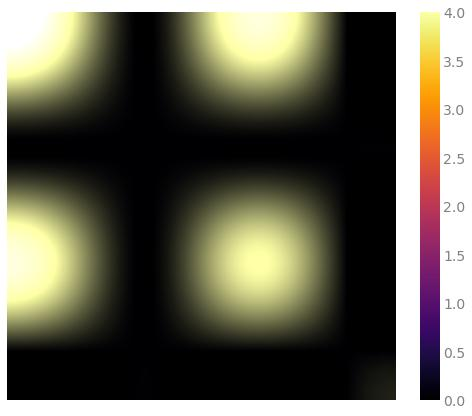

In [49]:
simshow(jnp.mean(scatter(ptcl_lpt,conf_lpt),axis=0))

(<Figure size 648x504 with 2 Axes>, <Axes: >)

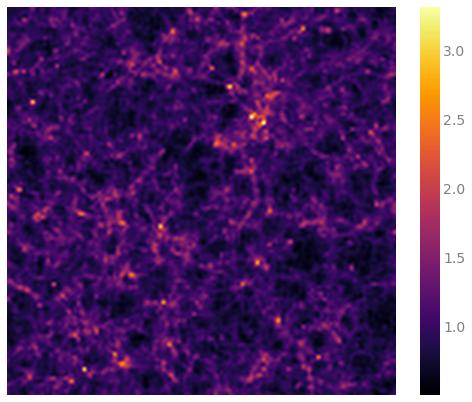

In [52]:
simshow(jnp.mean(scatter(ptcl_sub,conf_sub),axis=0))

Set up the configuration for a sub-box

Non-periodic FFT derivatives

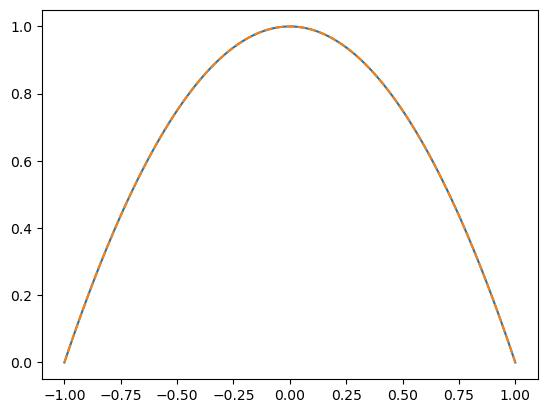

In [17]:
plt.plot(xx, f(xx), label='f')
plt.plot(xx,idst(dst(f(xx),type=1),type=1),ls='--')

In [62]:
dx=xx[1]-xx[0]
kk = (2*np.pi/dx)* np.linspace(0.0,0.5,len(xx)//2+1)

In [89]:
hatu=dct(f(xx),type=2)
#multiply by frequency, minus sign
for i in range(len(xx)):
    hatu[i]=-(i)*hatu[i]
#shift to left
hatu[0:len(xx)-1]=hatu[1:len(xx)]
hatu[len(xx)-1]=0.
dotu=idst(hatu,type=2)/(2*len(xx))

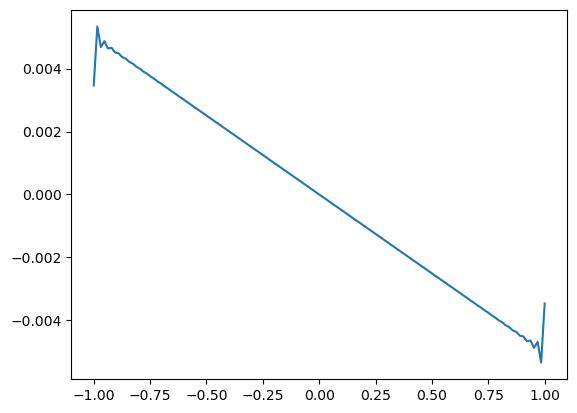

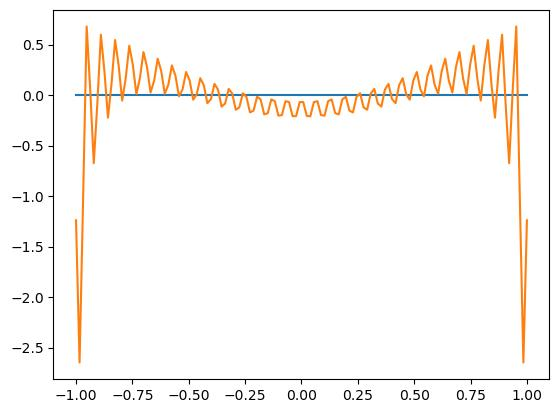

In [85]:
plt.plot(xx,np.real(idct(dst(f(xx),type=1) * (2*np.pi/dx)*1.j*np.fft.fftfreq(len(xx)),type=1)))

plt.plot(xx,np.imag(idst(dst(f(xx),type=1) * (2*np.pi/dx)*1.j*np.fft.fftfreq(len(xx)),type=1)))
plt.plot(xx,np.imag(idst(dst(f(xx),type=1) * (2*np.pi/dx)*1.j*np.fft.fftfreq(len(xx)),type=1)))


/global/homes/j/jsull/.conda/envs/pmwd/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


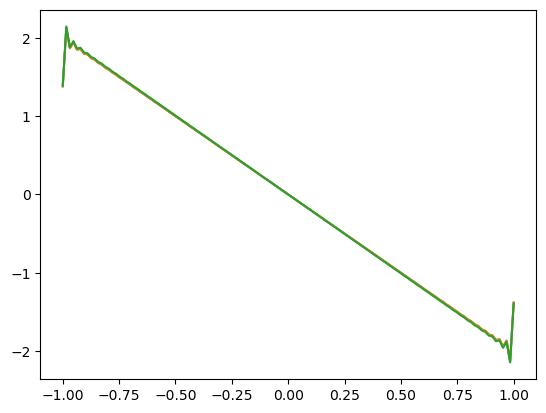

In [52]:
plt.plot(xx,np.imag(idst(dst(f(xx), type=1) * 1.j*np.fft.fftshift(kk), type=1)))
plt.plot(xx,df(xx))

ValueError: operands could not be broadcast together with shapes (128,) (100,) 

In [100]:
# 1d cheby pts

# function with known derivative
def f(x): return x**2#1 - x**2
def df(x): return 2*x#-2 * x
import numpy as np
xx = np.linspace(-1, 1, 128)
import matplotlib.pyplot as plt
# plt.plot(xx, f(xx), label='f')

from scipy.fft import dst, idst,dct,idct
def dst_df(f,k): 
    f = dst(f, type=1)
    N = len(f)
    f[N//2+1] = 0.0
    return idst(f * im * k, type=1)

# def cheb_df(x): 
#     # following trefethen

#     return

/global/homes/j/jsull/.conda/envs/pmwd/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


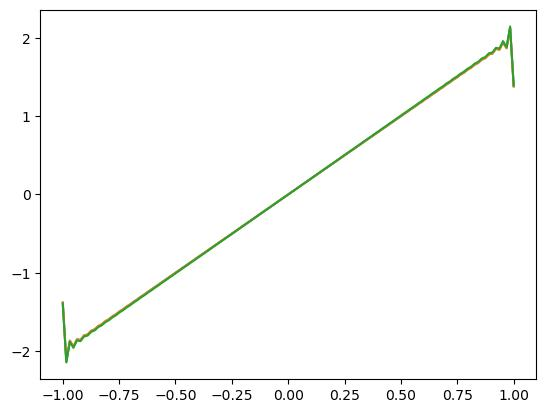

In [101]:
plt.plot(xx,np.fft.ifft(np.fft.fft(f(xx)) * (2*np.pi/dx)*1.j*np.fft.fftfreq(len(xx))))
plt.plot(xx,np.fft.irfft(np.fft.rfft(f(xx)) * 1.j*kk,len(xx)))
hatu=dct(f(xx),type=2)
#multiply by frequency, minus sign
for i in range(len(xx)):
    hatu[i]=-(i)*hatu[i]
#shift to left
hatu[0:len(xx)-1]=hatu[1:len(xx)]
hatu[len(xx)-1]=0.
dotu=idst(hatu,type=2)
plt.plot(xx,dotu*np.pi/2)

# plt.plot(xx,df(xx))

In [129]:
jfac = 1/np.sqrt(1-xtheta**2)
jfac[0]=0.0
jfac[-1]=0.0

/tmp/ipykernel_47422/3114751255.py:1: RuntimeWarning: divide by zero encountered in divide
  jfac = 1/np.sqrt(1-xtheta**2)


In [ ]:
CHEBFFT Chebyshev differentiation via FFT. Simple, not optimal.
If v is complex, delete "real" commands.
function w = chebfft(v)
N = length(v)-1; if N==O, w=0; return, end
x = cos((0:N)'*pi/N);
ii = O:N-1;
v = v(:); V = [v; flipud(v(2:N))]; % transform x -> theta
U = real(fft(V));
W = real(ifft(1i*[ii 0 1-N:-1]'.*U));
w = zeros(N+1,1);
w(2:N) = -W(2:N)./sgrt(1-x(2:N)."2); % transform theta -> x
w(1) = sum(ii'."2.*U(ii+1))/N + .5*N*U(N+1);
w(N+1) = sum((-1)."(ii+1)'.*ii'."2.*U(ii+1))/N + .5*(-1)"(N+1)*N*U(N+1);

In [307]:
def chebfft(v):
    # 1D chebyshev differentiation via fft (Input is assumed at the Chebyshev points) from Trefethen 2000 Ch 8 Alg 17
    # Here I believe we are eating a factor of 4 in memory wrt DST, but I couldn't figure the DST out...
    N = len(v)-1
    x = np.cos(np.arange(0,N+1)*np.pi/N)
    # print('xhspae',x.shape)
    ii = np.arange(0,N)
    # print('ii',ii.shape)
    V = np.concatenate((v,np.flipud(v[1:N])))
    # print('V',V.shape)
    U = np.real(np.fft.fft(V))
    # print("U",U)
    # print('ushape', U.shape)
    # print('1',(np.concatenate((np.array([0]),np.arange(1,N),np.array([0]),-np.arange(1,N)[::-1]))*U).shape)
    # print('2',ii.shape)
    # print('ahhh',1.j*np.concatenate((np.array([0]),np.arange(1,N),np.array([0]),-np.arange(1,N)[::-1])))
    
    # print('3',(1.j*np.concatenate((np.array([0]),np.arange(1,N),np.array([0]),-np.arange(1,N)[::-1]))*U).shape)
    W = np.real(np.fft.ifft(1.j*np.concatenate((np.array([0]),np.arange(1,N),np.array([0]),-np.arange(1,N)[::-1]))*U))
    # print(W.dtype)
    # print("W",W.shape)
    # print(W)
    w = np.zeros(N+1)
    # print(W[2:N].shape,np.sqrt(1-x[2:N]**2).shape)
    # print((-W[2:N]/np.sqrt(1-x[2:N]**2)).shape)
    w[1:N] = -W[1:N]/np.sqrt(1-x[1:N]**2)
    w[0] = np.sum(ii**2*U[ii])/N + 0.5*N*U[N]
    # print(w[0])
    w[N] = np.sum((-1)**(ii+1)*ii**2*U[ii])/N + 0.5*(-1)**(N+1)*N*U[N]
    # print("w",w.shape)
    return w    
    

In [317]:
%timeit chebfft(f(xtheta)) #pretty fast!

62.7 µs ± 980 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [309]:
matlabw = np.array([1.966740,
   1.956041,
   1.982741,
   2.049732,
   1.965761,
   1.987662,
   1.984991,
   1.968500,
   1.966857,
   1.951669,
   1.930241,
   1.923029,
   1.924137,
   1.882627,
   1.891482,
   1.857329,
   1.846851,
   1.831523,
   1.797389,
   1.787058,
   1.751885,
   1.746716,
   1.705862,
   1.686286,
   1.661108,
   1.625277,
   1.605120,
   1.567715,
   1.541053,
   1.505012,
   1.477256,
   1.438434,
   1.404080,
   1.368901,
   1.329760,
   1.300947,
   1.258001,
   1.218850,
   1.180662,
   1.136668,
   1.102106,
   1.050971,
   1.016989,
   0.968131,
   0.932783,
   0.880306,
   0.841662,
   0.794898,
   0.748058,
   0.701188,
   0.656096,
   0.606044,
   0.562970,
   0.512183,
   0.467080,
   0.416282,
   0.369933,
   0.319230,
   0.272105,
   0.221444,
   0.173750,
   0.122742,
   0.075090,
   0.023833,
  -0.023833,
  -0.075090,
  -0.122742,
  -0.173750,
  -0.221444,
  -0.272105,
  -0.319230,
  -0.369933,
  -0.416282,
  -0.467080,
  -0.512183,
  -0.562970,
  -0.606044,
  -0.656096,
  -0.701188,
  -0.748058,
  -0.794898,
  -0.841662,
  -0.880306,
  -0.932783,
  -0.968131,
  -1.016989,
  -1.050971,
  -1.102106,
  -1.136668,
  -1.180662,
  -1.218850,
  -1.258001,
  -1.300947,
  -1.329760,
  -1.368901,
  -1.404080,
  -1.438434,
  -1.477256,
  -1.505012,
  -1.541053,
  -1.567715,
  -1.605120,
  -1.625277,
  -1.661108,
  -1.686286,
  -1.705862,
  -1.746716,
  -1.751885,
  -1.787058,
  -1.797389,
  -1.831523,
  -1.846851,
  -1.857329,
  -1.891482,
  -1.882627,
  -1.924137,
  -1.923029,
  -1.930241,
  -1.951669,
  -1.966857,
  -1.968500,
  -1.984991,
  -1.987662,
  -1.965761,
  -2.049732,
  -1.982741,
  -1.956041,
  -1.966740])

In [310]:
chebfft(f(xtheta))

array([ 2.   ,  1.999,  1.998,  1.994,  1.99 ,  1.985,  1.978,  1.97 ,  1.961,  1.951,  1.939,  1.926,  1.913,  1.897,  1.881,
        1.864,  1.845,  1.826,  1.805,  1.783,  1.76 ,  1.736,  1.711,  1.685,  1.658,  1.63 ,  1.6  ,  1.57 ,  1.539,  1.507,
        1.474,  1.44 ,  1.405,  1.37 ,  1.333,  1.296,  1.258,  1.219,  1.18 ,  1.139,  1.098,  1.057,  1.014,  0.971,  0.928,
        0.884,  0.839,  0.794,  0.748,  0.702,  0.656,  0.609,  0.561,  0.514,  0.466,  0.417,  0.369,  0.32 ,  0.271,  0.222,
        0.173,  0.124,  0.074,  0.025, -0.025, -0.074, -0.124, -0.173, -0.222, -0.271, -0.32 , -0.369, -0.417, -0.466, -0.514,
       -0.561, -0.609, -0.656, -0.702, -0.748, -0.794, -0.839, -0.884, -0.928, -0.971, -1.014, -1.057, -1.098, -1.139, -1.18 ,
       -1.219, -1.258, -1.296, -1.333, -1.37 , -1.405, -1.44 , -1.474, -1.507, -1.539, -1.57 , -1.6  , -1.63 , -1.658, -1.685,
       -1.711, -1.736, -1.76 , -1.783, -1.805, -1.826, -1.845, -1.864, -1.881, -1.897, -1.913, -1.926, -1.939, 

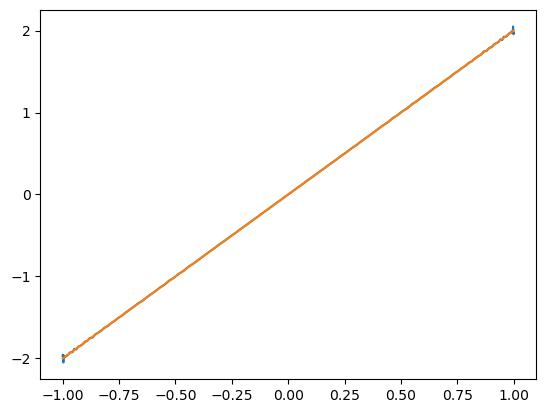

In [314]:
plt.plot(xtheta,matlabw)
plt.plot(xtheta,chebfft(f(xtheta)))


In [ ]:
# Ok great this works in 1D, now want to extend it to 3D


In [262]:
N=128
xtheta = np.cos(np.arange(N)/(N-1) * np.pi)
# plt.plot(xtheta,f(xtheta))
# fhat = np.fft.rfft(f(xtheta))
# fdot = np.fft.irfft(fhat.real * jfac*np.fft.rfftfreq(N+1),N+1)
fhat = np.fft.fft(f(xtheta))
fdot = np.fft.ifft(fhat.real * -1.j * jfac*np.fft.fftfreq(N+1),N+1)
plt.plot(xtheta,chebfft(f(xx)))
plt.plot(xtheta,fdot)

ValueError: operands could not be broadcast together with shapes (128,) (129,) 